# ADS 509 Assignment 2.1: Tokenization, Normalization, Descriptive Statistics 

This notebook holds Assignment 2.1 for Module 2 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In the previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we explore some of the textual features of those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 

This assignment asks you to write a short function to calculate some descriptive statistics on a piece of text. Then you are asked to find some interesting and unique statistics on your corpora. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation

swe = stopwords.words("english") + ['https', 'co']
swi = stopwords.words("italian")
sws = stopwords.words("spanish")
swf = stopwords.words("french")

In [2]:
# Add any additional import statements you need here
import glob
import string
from nltk.tokenize import word_tokenize

In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/dallinmunger/Desktop/USD_Work/ADS 509/Module 1/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

In [4]:
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """

    # Fill in the correct values here. 
    num_tokens = len(tokens)
    num_unique_tokens = len(Counter(tokens))
    lexical_diversity = num_unique_tokens/num_tokens
    num_characters = sum([len(i) for i in tokens])
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        print(Counter(tokens).most_common(5))
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])
    

In [5]:
text = """here is some example text with other example text here in this text""".split()
assert(descriptive_stats(text, verbose=True)[0] == 13)
assert(descriptive_stats(text, verbose=False)[1] == 9)
assert(abs(descriptive_stats(text, verbose=False)[2] - 0.69) < 0.02)
assert(descriptive_stats(text, verbose=False)[3] == 55)

There are 13 tokens in the data.
There are 9 unique tokens in the data.
There are 55 characters in the data.
The lexical diversity is 0.692 in the data.
[('text', 3), ('here', 2), ('example', 2), ('is', 1), ('some', 1)]


Q: Why is it beneficial to use assertion statements in your code? 

A: Assert statements allow you to catch any issues in your code before you continue to move forward. It makes the debugging process easier.

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [6]:
artists = ['andreabocelli', 'joshgroban']
# Read in the lyrics data

# Create empty lists
songs = []
title = []
artist_name = []
for i in range(len(artists)):
    # Create path to files
    name = data_location + lyrics_folder + artists[i] + '/*.txt'
    # Read in all song files, add to list
    songs.append([open(filename).read() for filename in glob.glob(name)])
    # Extract title from the songs, add to list
    title.append([re.findall(r'"([^"]*)"', i) for i in songs[i]])
    # Create list of artist name
    artist_name.append([artists[i]]*len(songs[i]))
lyrics_df = pd.DataFrame()
title = title[0] + title[1]
lyrics_df['title'] = sum(title, [])
lyrics_df['artist_name'] = artist_name[0] + artist_name[1]
lyrics_df['songs'] = songs[0] + songs[1]

In [7]:
# Read in the twitter data
bocelli_followers = pd.read_csv(data_location + twitter_folder + '/AndreaBocelli_followers_data.txt', sep = '\t')
groban_followers = pd.read_csv(data_location + twitter_folder + '/joshgroban_followers_data.txt', sep = '\t')
# Create twitter df with artist name as one column, descriptions as the other
twitter_df = pd.DataFrame()
twitter_df['artist_name'] = ['andreabocelli']*len(bocelli_followers) + ['joshgroban']*len(groban_followers)
twitter_df['description'] = pd.concat([bocelli_followers['description'],groban_followers['description']], axis = 0, ignore_index = True)

## Data Cleaning

Now clean and tokenize your data. Remove punctuation chacters (available in the `punctuation` object in the `string` library), split on whitespace, fold to lowercase, and remove stopwords. Store your cleaned data, which must be accessible as an interable for `descriptive_stats`, in new objects or in new columns in your data frame. 



In [8]:
# Add '’' to the string
punctuation = punctuation + '’'
# Remove '#' from the string
punctuation = punctuation.replace('#', '')
punctuation = set(punctuation) # speeds up comparison 

In [9]:
# create your clean twitter data here
# Set all NAs to blank text
twitter_df = twitter_df.fillna('')
# Create function to clean text data
def clean_text_data(column):
    new_description = []
    for description in column:
        update_desc = description
        # Remove the punctuation from each description
        for i in description:
            if i in punctuation:
                update_desc = update_desc.replace(i, " ")
        # Remove extra white space
        update_desc = re.sub(r'\s+', ' ', update_desc)
        # Split on whitespace
        update_desc = update_desc.split()
        update_desc = sum([emoji.get_emoji_regexp().split(i) for i in update_desc],[])
        # Fold to lowercase
        for i in range(len(update_desc)):
            update_desc[i] = update_desc[i].lower()
        # Remove stopwords
        update_desc = [i for i in update_desc if i not in swe and i not in swi and i not in sws and i not in swf]
        # Remove blank items
        update_desc = [j for j in update_desc if j]
        new_description.append(update_desc)
    return new_description

# Clean twitter descriptions and add as new column
twitter_df['cleaned_description'] = clean_text_data(twitter_df['description'])

In [10]:
# create your clean lyrics data here
lyrics_df['cleaned_lyrics'] = clean_text_data(lyrics_df['songs'])

## Basic Descriptive Statistics

Call your `descriptive_stats` function on both your lyrics data and your twitter data and for both artists (four total calls). 

In [11]:
# calls to descriptive_stats here
# Andrea Bocelli lyrics
print("Andrea Bocelli Lyrics:")
descriptive_stats(sum(lyrics_df.loc[lyrics_df['artist_name'] == 'andreabocelli', 'cleaned_lyrics'], []))
# Josh Groban lyrics
print("\nJosh Groban Lyrics:")
descriptive_stats(sum(lyrics_df.loc[lyrics_df['artist_name'] == 'joshgroban', 'cleaned_lyrics'], []))
#Andrew Bocelli followers
print("\nAndrea Bocelli Followers:")
descriptive_stats(sum(twitter_df.loc[twitter_df['artist_name'] == 'andreabocelli', 'cleaned_description'], []))
#Josh Groban followers
print("\nJosh Groban Followers:")
descriptive_stats(sum(twitter_df.loc[twitter_df['artist_name'] == 'joshgroban', 'cleaned_description'], []))

Andrea Bocelli Lyrics:
There are 1679 tokens in the data.
There are 837 unique tokens in the data.
There are 9313 characters in the data.
The lexical diversity is 0.499 in the data.
[('vivo', 33), ('mai', 24), ('vita', 23), ('amore', 22), ('vivere', 22)]

Josh Groban Lyrics:
There are 1700 tokens in the data.
There are 806 unique tokens in the data.
There are 9191 characters in the data.
The lexical diversity is 0.474 in the data.
[('amore', 28), ('love', 21), ('say', 19), ('still', 18), ('sempre', 17)]

Andrea Bocelli Followers:
There are 25239 tokens in the data.
There are 12430 unique tokens in the data.
There are 142138 characters in the data.
The lexical diversity is 0.492 in the data.
[('love', 165), ('❤️', 121), ('music', 118), ('life', 109), ('fan', 81)]

Josh Groban Followers:
There are 29715 tokens in the data.
There are 11297 unique tokens in the data.
There are 165738 characters in the data.
The lexical diversity is 0.380 in the data.
[('love', 332), ('music', 214), ('life'

[29715, 11297, 0.380178361097089, 165738]

Q: How do you think the "top 5 words" would be different if we left stopwords in the data? 

A: The top 5 words would likely consist primarily of stopwords.

---

Q: What were your prior beliefs about the lexical diversity between the artists? Does the difference (or lack thereof) in lexical diversity between the artists conform to your prior beliefs? 

A: I believed before that they would be similar since they are in the same genre and sing similar songs. The similarity confirms my prior beliefs, and it is interesting to see how almost identical they are in lexical diversity.



## Specialty Statistics

The descriptive statistics we have calculated are quite generic. You will now calculate a handful of statistics tailored to these data.

1. Ten most common emojis by artist in the twitter descriptions.
1. Ten most common hashtags by artist in the twitter descriptions.
1. Five most common words in song titles by artist. 
1. For each artist, a histogram of song lengths (in terms of number of tokens) 

We can use the `emoji` library to help us identify emojis and you have been given a function to help you.


In [12]:
def is_emoji(s):
    return(s in emoji.UNICODE_EMOJI['en'])

assert(is_emoji("❤️"))
assert(not is_emoji(":-)"))

### Emojis 😁

What are the ten most common emojis by artist in the twitter descriptions? 


In [13]:
def count_emojis(artist):
    # Create list with all words in all descriptions for each artist
    descriptions = sum(twitter_df.loc[twitter_df['artist_name'] == artist, 'cleaned_description'], [])
    # Filter lists to include only emojis
    emojis = [i for i in descriptions if is_emoji(i)]
    # Count ten most common emojis
    return print(Counter(emojis).most_common(10))
print('Andrea Bocelli most common emojis:')
count_emojis('andreabocelli')
print('\nJosh Groban most common emojis:')
count_emojis('joshgroban')

Andrea Bocelli most common emojis:
[('❤️', 121), ('💙', 76), ('❤', 61), ('✨', 55), ('💜', 55), ('🇺🇸', 40), ('🌊', 40), ('💛', 36), ('📚', 30), ('🎶', 30)]

Josh Groban most common emojis:
[('❤️', 110), ('🌸', 70), ('💙', 68), ('❤', 65), ('✨', 54), ('🇺🇸', 53), ('🎶', 51), ('🏳️\u200d🌈', 51), ('💜', 39), ('💕', 33)]


### Hashtags

What are the ten most common hashtags by artist in the twitter descriptions? 


In [14]:
def count_hashtags(artist):
    # Create list with all words in all descriptions for each artist
    descriptions = sum(twitter_df.loc[twitter_df['artist_name'] == artist, 'cleaned_description'], [])
    # Filter to only include hashtags
    hashtags = [i for i in descriptions if i.startswith('#') and len(i) > 1]
    # Count ten most common hashtags
    return print(Counter(hashtags).most_common(10))
print('Andrea Bocelli most common hashtagas:')
count_hashtags('andreabocelli')
print('\nJosh Groban most common hashtags:')
count_hashtags('joshgroban')

Andrea Bocelli most common hashtagas:
[('#bitcoin', 13), ('#blm', 7), ('#music', 6), ('#resist', 5), ('#voteblue', 4), ('#standwithukraine', 3), ('#btc', 3), ('#science', 3), ('#travel', 3), ('#mufc', 3)]

Josh Groban most common hashtags:
[('#blm', 14), ('#blacklivesmatter', 11), ('#actuallyautistic', 5), ('#bekind', 5), ('#resist', 5), ('#writer', 4), ('#standwithukraine', 4), ('#maga', 4), ('#autism', 4), ('#music', 4)]


### Song Titles

What are the five most common words in song titles by artist? The song titles should be on the first line of the lyrics pages, so if you have kept the raw file contents around, you will not need to re-read the data.


In [15]:
# Clean the title column for lyrics
lyrics_df['title'] = clean_text_data(lyrics_df['title'])
# Filter by artist and create list of all title words
bocelli_titles = sum(lyrics_df.loc[lyrics_df['artist_name'] == 'andreabocelli', 'title'], [])
groban_titles = sum(lyrics_df.loc[lyrics_df['artist_name'] == 'joshgroban', 'title'], [])
print('Andrea Bocelli most common title words (Without stop words):')
print(Counter(bocelli_titles).most_common(5))
print('\nJosh Groban most common title words (Without stop words):')
print(Counter(groban_titles).most_common(5))

Andrea Bocelli most common title words (Without stop words):
[('vivo', 1), ('lucevan', 1), ('stelle', 1), ('vivere', 1), ('caruso', 1)]

Josh Groban most common title words (Without stop words):
[('sempre', 2), ('starry', 2), ('oceano', 1), ('amore', 1), ('cinema', 1)]


### Song Lengths

For each artist, a histogram of song lengths (in terms of number of tokens). If you put the song lengths in a data frame with an artist column, matplotlib will make the plotting quite easy. An example is given to help you out. 


artist
Artist 1    AxesSubplot(0.125,0.125;0.775x0.755)
Artist 2    AxesSubplot(0.125,0.125;0.775x0.755)
Name: length, dtype: object

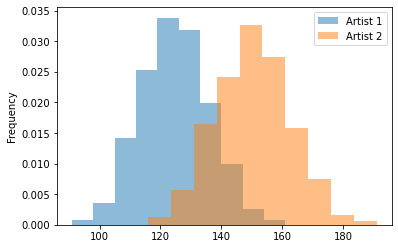

In [16]:
num_replicates = 1000

df = pd.DataFrame({
    "artist" : ['Artist 1'] * num_replicates + ['Artist 2']*num_replicates,
    "length" : np.concatenate((np.random.poisson(125,num_replicates),np.random.poisson(150,num_replicates)))
})

df.groupby('artist')['length'].plot(kind="hist",density=True,alpha=0.5,legend=True)

Since the lyrics may be stored with carriage returns or tabs, it may be useful to have a function that can collapse whitespace, using regular expressions, and be used for splitting. 

Q: What does the regular expression `'\s+'` match on? 

A: It matches any number of whitespace characters.


In [17]:
collapse_whitespace = re.compile(r'\s+')

def tokenize_lyrics(lyric) : 
    """strip and split on whitespace"""
    return([item.lower() for item in collapse_whitespace.split(lyric)])

artist_name
andreabocelli    AxesSubplot(0.125,0.125;0.775x0.755)
joshgroban       AxesSubplot(0.125,0.125;0.775x0.755)
Name: length, dtype: object

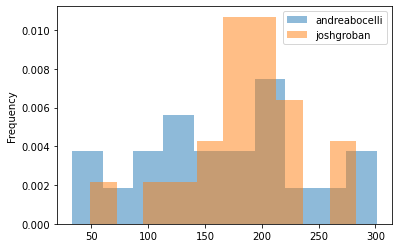

In [18]:
# Your lyric length comparison chart here. 
# Tokenize and calculate length
lyrics_df['tokenized_lyrics'] = [tokenize_lyrics(i) for i in lyrics_df['songs']]
lyrics_df['length'] = [len(i) for i in lyrics_df['tokenized_lyrics']]
# Create the chart
lyrics_df.groupby('artist_name')['length'].plot(kind="hist",density=True,alpha=0.5,legend=True)